# 3546 Deep Learning - Term Project: Dimensionality reduction of financial time series and applications using a variational autoencoder

# Notebook 1/2: Data treatment

## April 10, 2019
## By:
* Lagnassa Marie Imokoyende
* Humberto Ribeiro de Souza

This notebook describes data treatment steps we followed to prepare the data before using the variational autoencoder. 
The stock data presented in this notebook was anonymized. It was obtained from Yahoo Finance using the python module Yahoo Financials. It can be downloaded at: https://pypi.org/project/yahoofinancials/.

The futures data was obtained from https://www.quandl.com/.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Link the notebook with Google Drive

In [2]:
#Set this variable only if you are running local.
# RUN_LOCAL=0 will point to the Google Drive
# RUN_LOCAL=1 assume you are running local or on equivalent mounting. 
#   It assumes that the xlsx files are in the same folder

RUN_LOCAL=1
PATH_FILES = '.'

In [3]:

if RUN_LOCAL==0:
    from google.colab import drive
    drive.mount('/content/gdrive')
    ## We check the access
    PATH_FILES = '/content/gdrive/My Drive/Datasets/3546 Final Project'
    print(os.listdir(PATH_FILES))
    

## Stocks Dataframe

### Load the stock data we previously downloaded

In [4]:
stock_data = pd.read_excel(PATH_FILES + '/stocks_data.xlsx')

### Remove weekends, holidays and NaN values

In [5]:
# Remove the weekend and holidays
# We will use a well known stock (anonymized ticker: 'EAGH') as our reference data to detect weekends and public holidays
stock_data = stock_data[pd.notnull(stock_data['EAGH'])]

In [6]:
# Count the number of stocks in the initial dataset:
initial_stocks_num = len(stock_data.columns)
initial_stocks_num

621

In [7]:
# Count the number of rows after removing weekends and holdiays
initial_n_rows = len(stock_data)
initial_n_rows

791

In [8]:
#After removing weekend and holidays, we clean the data further by removing columns which still contains NaN values
#Drop tickers for which there are NaN values
stock_data.dropna(axis='columns', inplace = True)

In [9]:
# Count the number of stocks left:
len(stock_data.columns)

423

In [10]:
# Count the number of stocks dropped
initial_stocks_num - len(stock_data.columns)

198

Price information is not available everyday for some stocks. We chose to remove those stocks from the dataset.

In [11]:
# We further drop all rows with 0
stock_data = stock_data[(stock_data != 0)]

In [12]:
# Count the number of rows with 0 removed from the dataset
initial_n_rows - len(stock_data)

0

Fortunately there was no 0 row in the dataset.

In [13]:
# We display the top 5 lines
stock_data.head()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2016-01-04,217.60,42.08,1286.74,531.33,207.00,128.26,404.89,77.95,306.58,68.23,...,3.42,4.74,1.20,111.0,3.55,2.07,4.14,3.80,3.78,16.0
2016-01-05,217.60,42.08,1286.74,525.41,207.00,128.26,404.89,78.52,306.58,66.32,...,3.40,4.58,1.20,110.3,3.65,2.09,4.10,3.25,3.78,16.0
2016-01-06,217.60,41.14,1286.74,525.41,207.00,127.03,404.89,78.52,306.58,66.32,...,3.22,4.58,1.19,114.5,3.80,2.03,4.19,3.25,3.78,16.0
2016-01-07,211.42,39.25,1286.74,525.41,197.45,123.23,404.89,78.52,297.25,66.32,...,3.09,4.46,1.21,110.4,3.85,2.10,4.10,3.25,3.78,16.0
2016-01-08,211.42,39.68,1244.53,525.41,197.45,121.36,401.04,76.28,297.25,62.26,...,3.26,4.50,1.21,111.4,3.77,2.02,4.19,3.25,3.78,16.0


Text(0.5,1,'Sample Time Series')

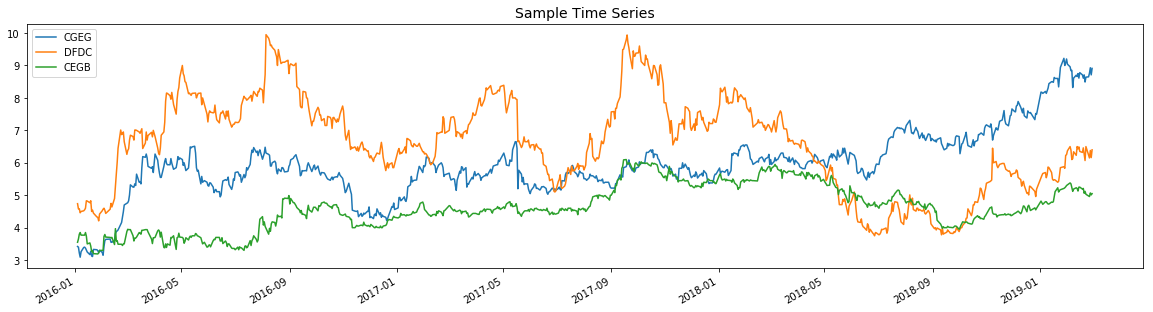

In [14]:
# We plot a few time series
fig, axis = plt.subplots(figsize=(20,5))
stock_data[['CGEG','DFDC','CEGB']].plot(ax = axis)
axis.set_title('Sample Time Series', fontsize = 14)

## Futures (front month) Time Series

The goal of our project is to detect stocks that are close to either another stock in the same market or a different asset class in another market.
We will use the front month data of a futures contract trading in another market (in a different country and with a different currency).  The data has been anonymized as well.

### Let's load the data

In [15]:
futures_data = pd.read_excel( PATH_FILES + '/futures_data_frontMonth.xlsx', index_col = 0)
futures_data.index = pd.to_datetime(futures_data.index) #Convert the index to a datetime index
futures_data.sort_index(inplace = True)

In [16]:
futures_data.head()

,Settle
Date,
2015-01-02,123.10
2015-01-05,122.00
2015-01-06,121.68
2015-01-07,120.95
2015-01-08,121.18


Since we compare financial data in different countries, we have to deal with the difference in public holidays. It is crucial to align the futures_data index with the stock_dataframe index so that only the common business days across both markets are kept. 
One way to achieve that is to:


1.   Keep the indices of *futures_data* that are also in the *stock_data* dataframe
2.   Update the *stock_data* dataframe to have the same index as in *futures_data* dataframe.



### First, we will only keep the indices of *futures_data* that are also in the *stock_data* dataframe

In [17]:
# Only keep values that are also in stock_data dataframe and drop NaN values
futures_data_stock_data = futures_data.loc[futures_data.index.isin(stock_data.index)].dropna()
# We further drop all rows with 0
futures_data = futures_data_stock_data[(futures_data_stock_data != 0)]

In [18]:
print('len(futures_data) =',len(futures_data))
print('len(stock_data) =',len(stock_data))

len(futures_data) = 782
len(stock_data) = 791


### Then, we update the *stock_data* dataframe to make it have the same index as in the *futures_data_stock_data* dataframe created above

In [19]:
stock_data = stock_data[stock_data.index.isin(futures_data_stock_data.index)]

In [20]:
# Length Verification
print('len(futures_data) =',len(futures_data))
print('len(stock_data) =',len(stock_data))

len(futures_data) = 782
len(stock_data) = 782


## Geometric moving average

The geometric moving average calculates a series of geometric mean of different subsets of the full dataset.
To compare time series of various price ranges, we will compute the geometric moving average time series of returns which is defined as:


$$ \large geoMA_t(d) = \sqrt[d]{(1+r_{t-1})(1+r_{t-2})\ldots(1+r_{t-d})} $$


where $\normalsize r_t $ is the financial asset return for day **t**.

We chose d=5, because we are interested in the weekly geometric moving average and a typical trading week has 5 business days.

For each given day, we will compute the geometric moving average over the last 5 business days.

In order to calculate the geoMA(5) we need to first calculate the daily percentage change of both dataframes.

### Calculate the percentage change for both dataframes

In [21]:
stock_data_pct_change = stock_data.pct_change()
futures_data_pct_change = futures_data.pct_change()

# Remove the first line, as it will have NaN values
stock_data_pct_change.dropna(inplace = True)
futures_data_pct_change.dropna(inplace = True)

In [22]:
stock_data_pct_change.head()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2016-01-05,0.000000,0.000000,0.000000,-0.011142,0.000000,0.000000,0.000000,0.007312,0.000000,-0.027994,...,-0.005848,-0.033755,0.000000,-0.006306,0.028169,0.009662,-0.009662,-0.144737,0.0,0.0
2016-01-06,0.000000,-0.022338,0.000000,0.000000,0.000000,-0.009590,0.000000,0.000000,0.000000,0.000000,...,-0.052941,0.000000,-0.008333,0.038078,0.041096,-0.028708,0.021951,0.000000,0.0,0.0
2016-01-07,-0.028401,-0.045941,0.000000,0.000000,-0.046135,-0.029914,0.000000,0.000000,-0.030433,0.000000,...,-0.040373,-0.026201,0.016807,-0.035808,0.013158,0.034483,-0.021480,0.000000,0.0,0.0
2016-01-08,0.000000,0.010955,-0.032804,0.000000,0.000000,-0.015175,-0.009509,-0.028528,0.000000,-0.061218,...,0.055016,0.008969,0.000000,0.009058,-0.020779,-0.038095,0.021951,0.000000,0.0,0.0
2016-01-11,-0.009602,0.002520,-0.019614,0.000000,-0.020663,-0.024390,0.000000,-0.030152,-0.003028,-0.021683,...,0.039877,0.004444,-0.008264,-0.017056,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [23]:
futures_data_pct_change.head()

,Settle
Date,
2016-01-05,0.002274
2016-01-06,-0.003176
2016-01-07,-0.010242
2016-01-08,-0.001495
2016-01-11,-0.021879


### Calculate the 5-day geometric moving average for both dataframes

#### For the *stock_data* dataframe

In [24]:
geoMA_5d_stocks = pd.DataFrame(columns = stock_data_pct_change.columns, index = stock_data_pct_change.index)

d = 5
for i in range(len(geoMA_5d_stocks.columns)):
    for j in range(d,len(geoMA_5d_stocks)):
        mult = 1
        for k in range(1,1+d):
            mult = mult * (stock_data_pct_change.loc[stock_data_pct_change.index[j-k]][geoMA_5d_stocks.columns[i]]+1)
            geoMA_5d_stocks.loc[geoMA_5d_stocks.index[j]][geoMA_5d_stocks.columns[i]] = np.power(mult,1/d)
            
# We drop the NaN lines (the first 5 lines will contain NaN values due as we are calculating a 5-day moving average)
geoMA_5d_stocks.dropna(inplace=True)

In [25]:
# We display the top 5 lines
geoMA_5d_stocks.head()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2016-01-12,0.992338,0.988821,0.989424,0.997762,0.98647,0.984129,0.998091,0.9896,0.993235,0.977558,...,0.998239,0.99054,1,0.997283,1.0121,0.995122,1.0024,0.969215,1,1
2016-01-13,0.996175,0.992179,0.989424,1,0.993441,0.984129,0.995368,0.992397,0.995936,0.983125,...,1,0.998687,1,0.994871,1.00649,0.986229,1,1,1,1
2016-01-14,0.992404,0.993299,0.986959,0.992476,0.989088,0.981743,0.995041,0.992397,0.993604,0.981993,...,1.00915,1.00087,0.982598,0.985433,1.00262,0.984764,0.992735,1,1,1
2016-01-15,1.00201,1.00539,0.986959,0.996006,0.996686,0.991347,0.996768,1.00422,1.00071,0.982737,...,1.01385,1.01607,0.981118,0.983524,0.994219,0.965292,0.995074,0.954877,0.95483,1
2016-01-18,0.994636,0.997212,0.985798,0.996006,0.996686,0.989739,0.995659,1.00468,0.99449,0.986638,...,0.999386,1.01383,0.977525,0.981752,0.985247,0.966094,0.984744,0.954877,0.95483,1


In [26]:
# We save the dataframe in our current folder
geoMA_5d_stocks.to_excel(PATH_FILES +'/geoMA_5d_stocks.xlsx')

Text(0,0.5,'5-day Geometric MA')

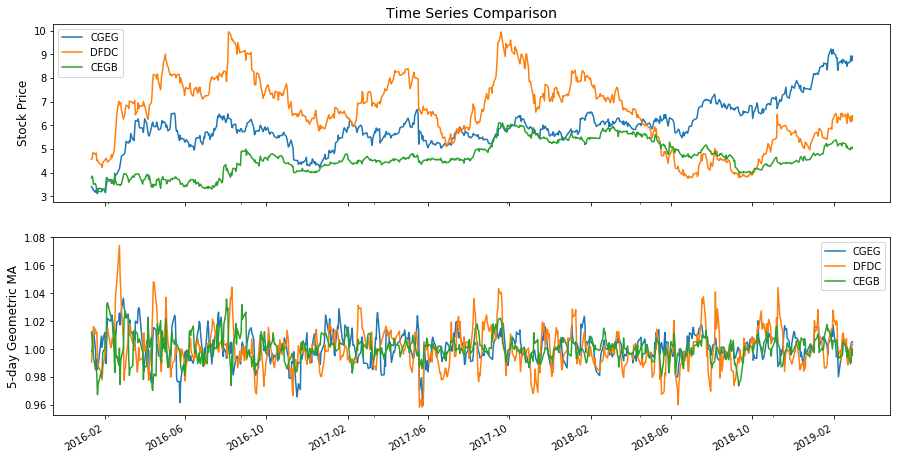

In [27]:
# We plot both the stock prices and geometric moving averages time series
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,8))
stock_data[['CGEG','DFDC','CEGB']].loc[geoMA_5d_stocks.index[0]:].plot(ax=axes[0])
axes[0].set_ylabel('Stock Price', fontsize = 12)
axes[0].set_title('Time Series Comparison', fontsize = 14)
geoMA_5d_stocks[['CGEG','DFDC','CEGB']].plot(ax=axes[1])
axes[1].set_ylabel('5-day Geometric MA', fontsize = 12)

#### For the *futures_data* dataframe

We also need to compute the geometric moving average for the futures dataframe:

In [28]:
geoMA_5d_futures = pd.DataFrame(columns = futures_data_pct_change.columns, index = futures_data_pct_change.index)

d = 5
for i in range(len(geoMA_5d_futures.columns)):
    for j in range(d,len(geoMA_5d_futures)):
        mult = 1
        for k in range(1,1+d):
            mult = mult * (futures_data_pct_change.loc[futures_data_pct_change.index[j-k]][geoMA_5d_futures.columns[i]]+1)
            geoMA_5d_futures.loc[geoMA_5d_futures.index[j]][geoMA_5d_futures.columns[i]] = np.power(mult,1/d)

# We drop the NaN lines (the first 5 lines will contain NaN values due as we are calculating a 5-day moving average)
geoMA_5d_futures.dropna(inplace=True)

In [29]:
# We display the top 5 lines
geoMA_5d_futures.head()

,Settle
Date,
2016-01-12,0.99306
2016-01-13,0.991061
2016-01-14,0.992256
2016-01-15,0.99769
2016-01-18,0.995562


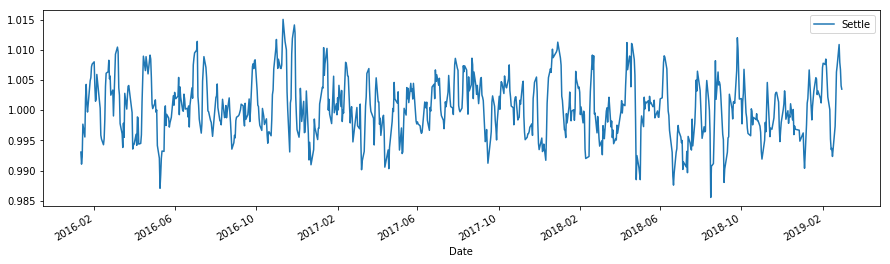

In [30]:
# We plot the time series of the commodities dataframe
geoMA_5d_futures.plot(figsize=(15,4))

In [31]:
# We save the dataframe in our current folder
geoMA_5d_futures.to_excel(PATH_FILES+'/geoMA_5d_futures.xlsx')

This conludes the data treatment notebook.